In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load file
file_path = "./retail.xlsx"
df = pd.read_excel(file_path)

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.drop_duplicates(inplace=True)
df = df.dropna()

In [16]:
# Summary statstics of qualitative variables
df.drop(columns=['InvoiceNo', 'StockCode']).describe(include='object').T

,count,unique,top,freq
Description,401604,3896,WHITE HANGING HEART T-LIGHT HOLDER,2058
Country,401604,37,United Kingdom,356728


In [17]:
# Summary statstics of quantitative variables
df.drop(columns=['InvoiceDate', 'CustomerID']).describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0


In [308]:
# Count unique Occurences
num_unique_customers = df["CustomerID"].nunique()
num_unique_countries = df["Country"].nunique()
num_unique_products= df["StockCode"].nunique()
num_unique_transactions= df["InvoiceNo"].nunique()

# Print results
print(f"Number of entries: {df.shape[0]}")
print(f"Number of unique Customer IDs: {num_unique_customers}")
print(f"Number of unique Countries: {num_unique_countries}")
print(f"Number of unique Products: {num_unique_products}")
print(f"Number of unique Transactions: {num_unique_transactions}")

Number of entries: 401604
Number of unique Customer IDs: 4372
Number of unique Countries: 37
Number of unique Products: 3684
Number of unique Transactions: 22190


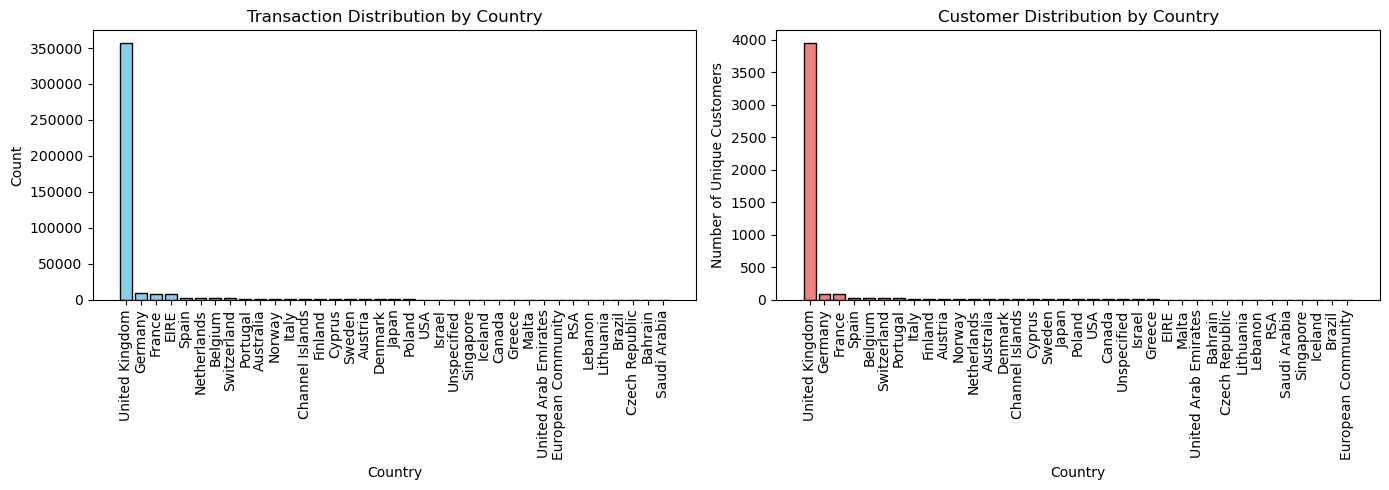

In [309]:
# EDA on countries

# Create parent figure
plt.figure(figsize=(14, 5))  

# Count occurrences of each country by transaction
country_counts = df["Country"].value_counts()
plt.subplot(1, 2, 1) 
plt.bar(country_counts.index, country_counts.values, color="skyblue", edgecolor="black")
plt.xticks(rotation=90) 
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Transaction Distribution by Country")

# Count the number of unique customers per country
customers_per_country = df.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False)
plt.subplot(1, 2, 2) 
plt.bar(customers_per_country.index, customers_per_country.values, color="lightcoral", edgecolor="black")
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Number of Unique Customers")
plt.title("Customer Distribution by Country")

plt.tight_layout()  
plt.show()

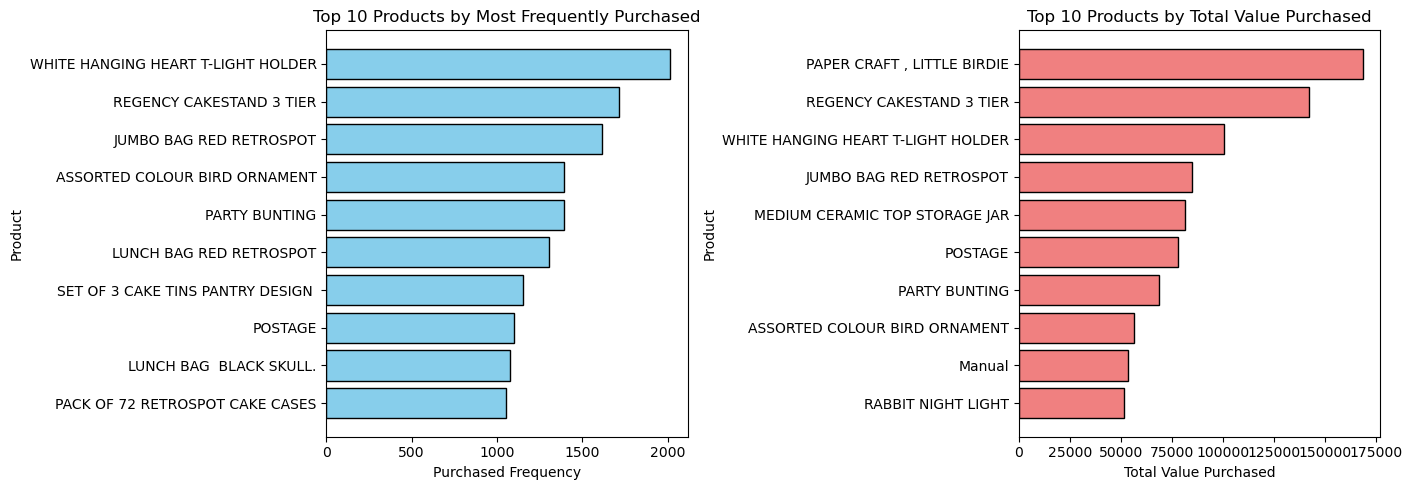

In [6]:
# EDA on products

# Create parent figure
plt.figure(figsize=(14, 5)) 

# Remove canceled products and create monetary columns to record the total value
df.loc[:, "Monetary"] = df["Quantity"] * df["UnitPrice"]
success_df = df[~df["InvoiceNo"].astype(str).str.startswith('C')]

# Plot the top 10 most purchased products
top_products = success_df["Description"].value_counts().head(10)

plt.subplot(1, 2, 1) 
plt.barh(top_products.index.astype(str), top_products.values, edgecolor='black', color='skyblue')
plt.xlabel("Purchased Frequency")
plt.ylabel("Product")
plt.title("Top 10 Products by Most Frequently Purchased")
plt.gca().invert_yaxis()

# Plot the top 10 most purchased products based on total value purchased
product_sales = success_df.groupby("Description")["Monetary"].sum()
top_products_value = product_sales.nlargest(10)
plt.subplot(1, 2, 2) 
plt.barh(top_products_value.index.astype(str), top_products_value.values, color='lightcoral', edgecolor='black')
plt.xlabel("Total Value Purchased")
plt.ylabel("Product")
plt.title("Top 10 Products by Total Value Purchased")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

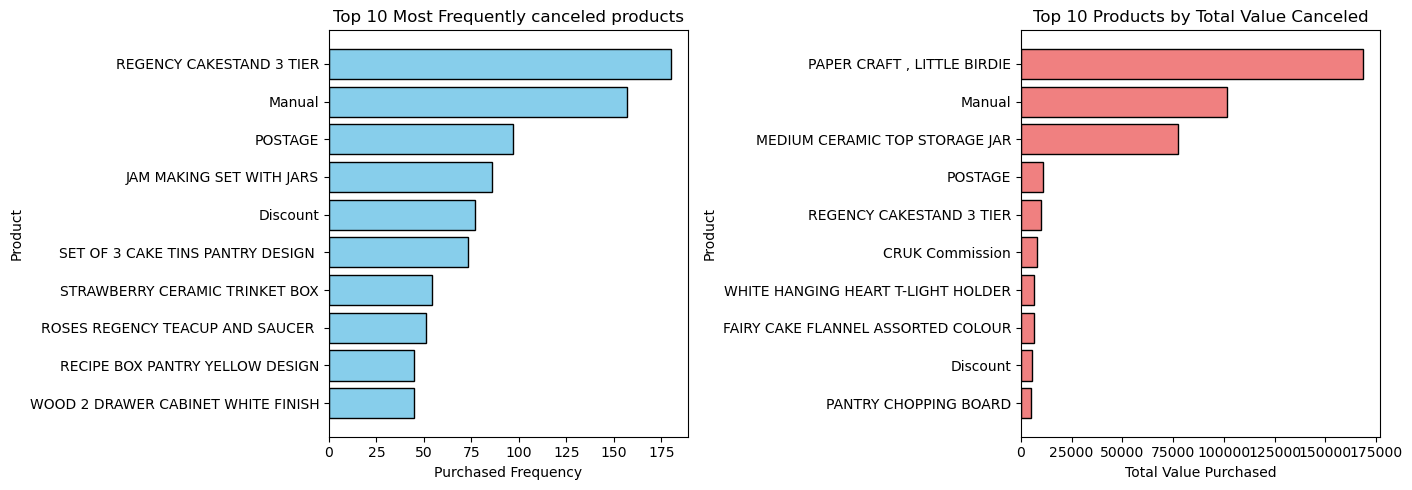

In [416]:
# EDA on canceled products

# Create parent figure
plt.figure(figsize=(14, 5)) 
canceled_items = df[df["InvoiceNo"].astype(str).str.startswith('C')]

# Plot the top 10 most purchased products
top_canceled_items = canceled_items["Description"].value_counts().head(10)
plt.subplot(1, 2, 1) 
plt.barh(top_canceled_items.index.astype(str), top_canceled_items.values, edgecolor='black', color='skyblue')
plt.xlabel("Purchased Frequency")
plt.ylabel("Product")
plt.title("Top 10 Most Frequently canceled products")
plt.gca().invert_yaxis()

# Plot the top 10 most purchased products based on total value purchased
product_sales = canceled_items.groupby("Description")["Monetary"].sum().abs()
top_products_value = product_sales.nlargest(10)
plt.subplot(1, 2, 2) 
plt.barh(top_products_value.index.astype(str), top_products_value.values, color='lightcoral', edgecolor='black')
plt.xlabel("Total Value Purchased")
plt.ylabel("Product")
plt.title("Top 10 Products by Total Value Canceled")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [26]:
# Create RFM Indexes and calculate cancellation rate for each customer

reference_date = df["InvoiceDate"].max()

# Compute RFM by creating a new df that groups by customer ID
rfm_df = df.groupby("CustomerID").agg(
    LastPurchaseDate=("InvoiceDate", "max"), 
    Frequency=("InvoiceNo", "nunique"), 
    Monetary=("Monetary", "sum") 
)
rfm_df["Recency"] = (reference_date - rfm_df["LastPurchaseDate"]).dt.days

# Compute cancellation percentage for each customer
df.loc[:, "Cancelled"] = df["InvoiceNo"].astype(str).str.startswith('C')
cancelled_percentage = df.groupby("CustomerID")["Cancelled"].mean() * 100
rfm_df = rfm_df.merge(cancelled_percentage.rename("Cancelled_Percentage"), on="CustomerID")

# Remove customers with a negative monetary value
negativeM_df = rfm_df[rfm_df["Monetary"] < 0]
rfm_df = rfm_df[rfm_df["Monetary"] >= 0]

In [27]:
negativeM_df.T

CustomerID,12503.0,12505.0,12605.0,12666.0,12870.0,12943.0,13154.0,13672.0,13693.0,13829.0,...,17065.0,17307.0,17448.0,17547.0,17548.0,17603.0,17820.0,18072.0,18141.0,18256.0
LastPurchaseDate,2011-01-06 11:51:00,2011-02-11 13:39:00,2010-12-09 15:41:00,2010-12-15 14:42:00,2010-12-08 14:27:00,2011-02-11 15:13:00,2011-07-18 15:21:00,2011-02-11 13:55:00,2011-01-18 15:23:00,2010-12-15 16:36:00,...,2011-07-19 14:45:00,2010-12-09 15:24:00,2011-07-18 12:26:00,2010-12-02 14:29:00,2011-05-06 10:00:00,2011-10-20 19:19:00,2011-06-01 15:14:00,2011-07-07 17:22:00,2010-12-14 11:09:00,2010-12-20 08:27:00
Frequency,1,1,1,1,1,1,1,6,2,1,...,1,1,1,1,3,5,2,2,1,1
Monetary,-1126.0,-4.5,-7.5,-227.44,-14.9,-3.75,-611.86,-71.46,-32.0,-102.0,...,-112.35,-152.64,-4287.63,-11.8,-141.48,-1165.3,-24.05,-0.0,-35.4,-50.1
Recency,337,300,364,358,365,300,143,300,324,358,...,142,364,144,371,217,49,190,154,360,354
Cancelled_Percentage,100.0,100.0,100.0,100.0,100.0,100.0,100.0,62.5,100.0,100.0,...,100.0,100.0,100.0,100.0,70.588235,26.666667,100.0,50.0,100.0,100.0


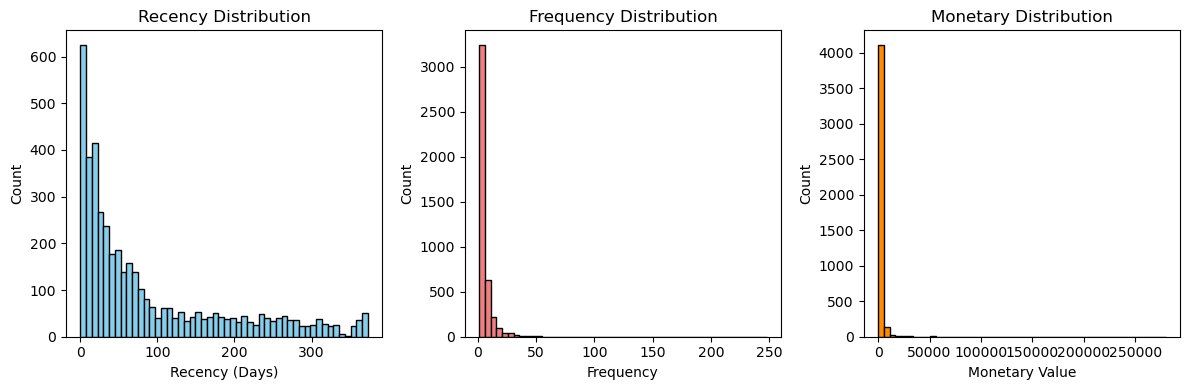

In [28]:
# Plot histograms for raw RFM values
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(rfm_df["Recency"], bins=50, color = "skyblue", edgecolor="black")
plt.xlabel("Recency (Days)")
plt.ylabel("Count")
plt.title("Recency Distribution")

plt.subplot(1, 3, 2)
plt.hist(rfm_df["Frequency"], bins=50, color = "lightcoral", edgecolor="black")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.title("Frequency Distribution")

plt.subplot(1, 3, 3)
plt.hist(rfm_df["Monetary"], bins=50, color = "darkorange", edgecolor="black")
plt.xlabel("Monetary Value")
plt.ylabel("Count")
plt.title("Monetary Distribution")

# Display histograms
plt.tight_layout()
plt.show()

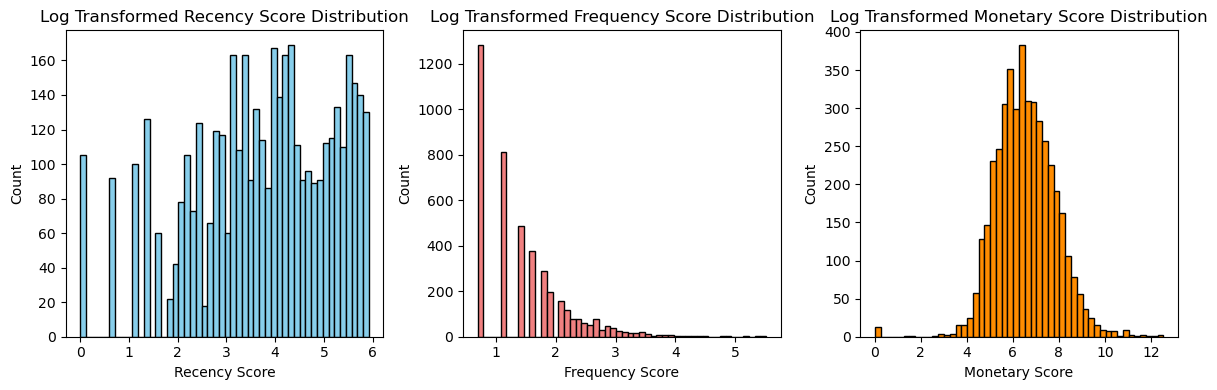

In [336]:
# Plot histograms for log transformed RFM values
plt.figure(figsize=(12, 4))

rfm_df["Log_Recency"] = np.log1p(rfm_df["Recency"])
rfm_df["Log_Frequency"] = np.log1p(rfm_df["Frequency"])
rfm_df["Log_Monetary"] = np.log1p(rfm_df["Monetary"])

plt.subplot(1, 3, 1)
plt.hist(rfm_df["Log_Recency"], bins=50, color = "skyblue", edgecolor="black")
plt.xlabel("Recency Score")
plt.ylabel("Count")
plt.title("Log Transformed Recency Score Distribution")

plt.subplot(1, 3, 2)
plt.hist(rfm_df["Log_Frequency"], bins=50, color = "lightcoral", edgecolor="black")
plt.xlabel("Frequency Score")
plt.ylabel("Count")
plt.title("Log Transformed Frequency Score Distribution")

plt.subplot(1, 3, 3)
plt.hist(rfm_df["Log_Monetary"], bins=50, color = "darkorange", edgecolor="black")
plt.xlabel("Monetary Score")
plt.ylabel("Count")
plt.title("Log Transformed Monetary Score Distribution")

# Display histograms
plt.tight_layout()
plt.show()

In [337]:
# Calculate the CAI index

cai_df = df
cai_df = df.sort_values(by=["CustomerID", "InvoiceDate"])

# Compute inter-purchase intervals (days between purchases)
cai_df["Interval"] = cai_df.groupby("CustomerID")["InvoiceDate"].diff().dt.days

# Assign increasing weights (starting from 1)
cai_df["Weight"] = cai_df.groupby("CustomerID").cumcount() + 1

# Compute weighted product of interval and weight
cai_df["Product"] = cai_df["Interval"] * cai_df["Weight"]

# Aggregate CAI components at the customer level
cai_df = cai_df.groupby("CustomerID").agg(
    Average_Interval=("Interval", "mean"),  # Step 1: Calculate average interval
    Sum_Weight=("Weight", "sum"),  # Step 2: Sum of weights
    Sum_Product=("Product", "sum")  # Step 3: Sum of weighted products
).reset_index()

# Step 4: Compute WMLE (Weighted Mean Logarithmic Expectation)
cai_df["WMLE"] = cai_df["Sum_Product"] / cai_df["Sum_Weight"]

# Compute CAI as the percentage change from WMLE
cai_df["CAI"] = ((cai_df["Average_Interval"] - cai_df["WMLE"]) / cai_df["WMLE"]) * 100
cai_df["CAI"] = cai_df["CAI"].replace([np.inf, -np.inf], np.nan).fillna(0)


# Merge CAI values back to the original dataframe
rfm_df = rfm_df.merge(cai_df[["CustomerID", "CAI"]], on="CustomerID")

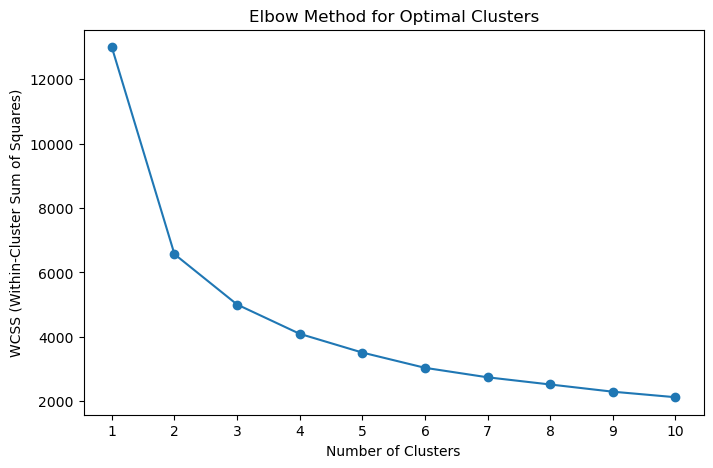

In [341]:
# Use the elbow method to search for optimal K

features = ["Log_Recency", "Log_Frequency", "Log_Monetary"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_df[features])

# Implementing the Elbow Method
wcss = []  
cluster_range = range(1, 11)  

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=14, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Store WCSS

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, wcss, marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal Clusters")
plt.xticks(cluster_range)
plt.show()

In [342]:
# Applying with optimal K = 3

kmeans = KMeans(n_clusters=3, random_state=139)  
rfm_df["class"] = kmeans.fit_predict(X_scaled) + 1

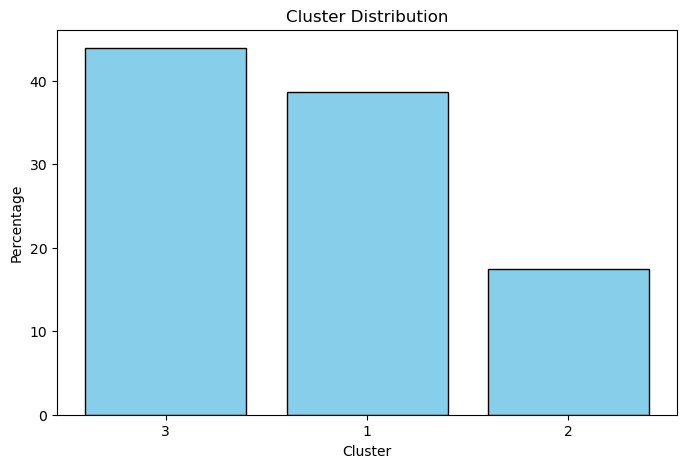

In [343]:
# Count the percentage of each cluster
cluster_counts = rfm_df["class"].value_counts(normalize=True) * 100

# Plot bar chart for cluster distribution
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.title("Cluster Distribution")
plt.show()

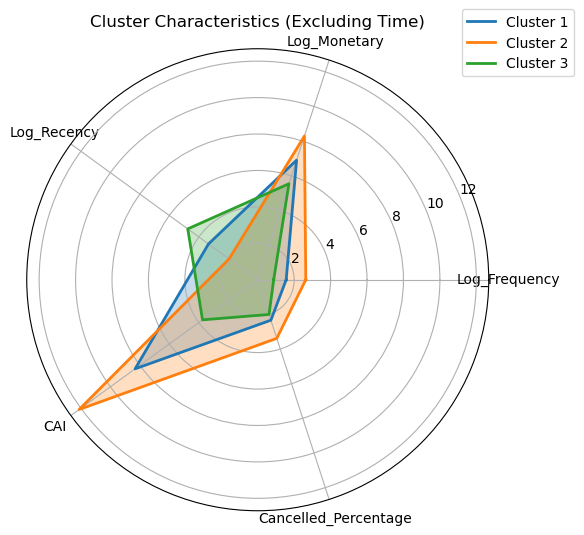

In [346]:
# Radar chart for each cluster 
cluster_means = rfm_df.groupby("class")[["Log_Frequency", "Log_Monetary", "Log_Recency", "CAI", "Cancelled_Percentage"]].mean()

labels = cluster_means.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].tolist()
    values += values[:1]  # Close the radar chart
    ax.plot(angles + [angles[0]], values, label=f"Cluster {cluster}", linewidth=2)
    ax.fill(angles + [angles[0]], values, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(labels)
ax.set_title("Cluster Characteristics (Excluding Time)")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()

In [358]:
rfm_df

,CustomerID,LastPurchaseDate,Frequency,Monetary,Recency,Cancelled_Percentage,Log_Recency,Log_Frequency,Log_Monetary,CAI,class
0,12346.0,2011-01-18 10:17:00,2,0.00,325,50.000000,5.786897,1.098612,0.000000,0.000000,3
1,12347.0,2011-12-07 15:52:00,7,4310.00,1,0.000000,0.693147,2.079442,8.368925,-2.801611,2
2,12348.0,2011-09-25 13:13:00,4,1797.24,74,0.000000,4.317488,1.609438,7.494564,-36.986079,1
3,12349.0,2011-11-21 09:51:00,1,1757.55,18,0.000000,2.944439,0.693147,7.472245,0.000000,1
4,12350.0,2011-02-02 16:01:00,1,334.40,309,0.000000,5.736572,0.693147,5.815324,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...
4325,18280.0,2011-03-07 09:52:00,1,180.60,277,0.000000,5.627621,0.693147,5.201806,0.000000,3
4326,18281.0,2011-06-12 10:53:00,1,80.82,180,0.000000,5.198497,0.693147,4.404522,0.000000,3
4327,18282.0,2011-12-02 11:43:00,3,176.60,7,7.692308,2.079442,1.386294,5.179534,-15.422180,1
4328,18283.0,2011-12-06 12:02:00,16,2045.53,3,0.000000,1.386294,2.833213,7.623901,28.082253,2


In [377]:
df = df.merge(rfm_df[["CustomerID", "class"]], on="CustomerID", how="right") # Merge class back to original df
df["Transaction_Hour"] = df["InvoiceDate"].dt.hour

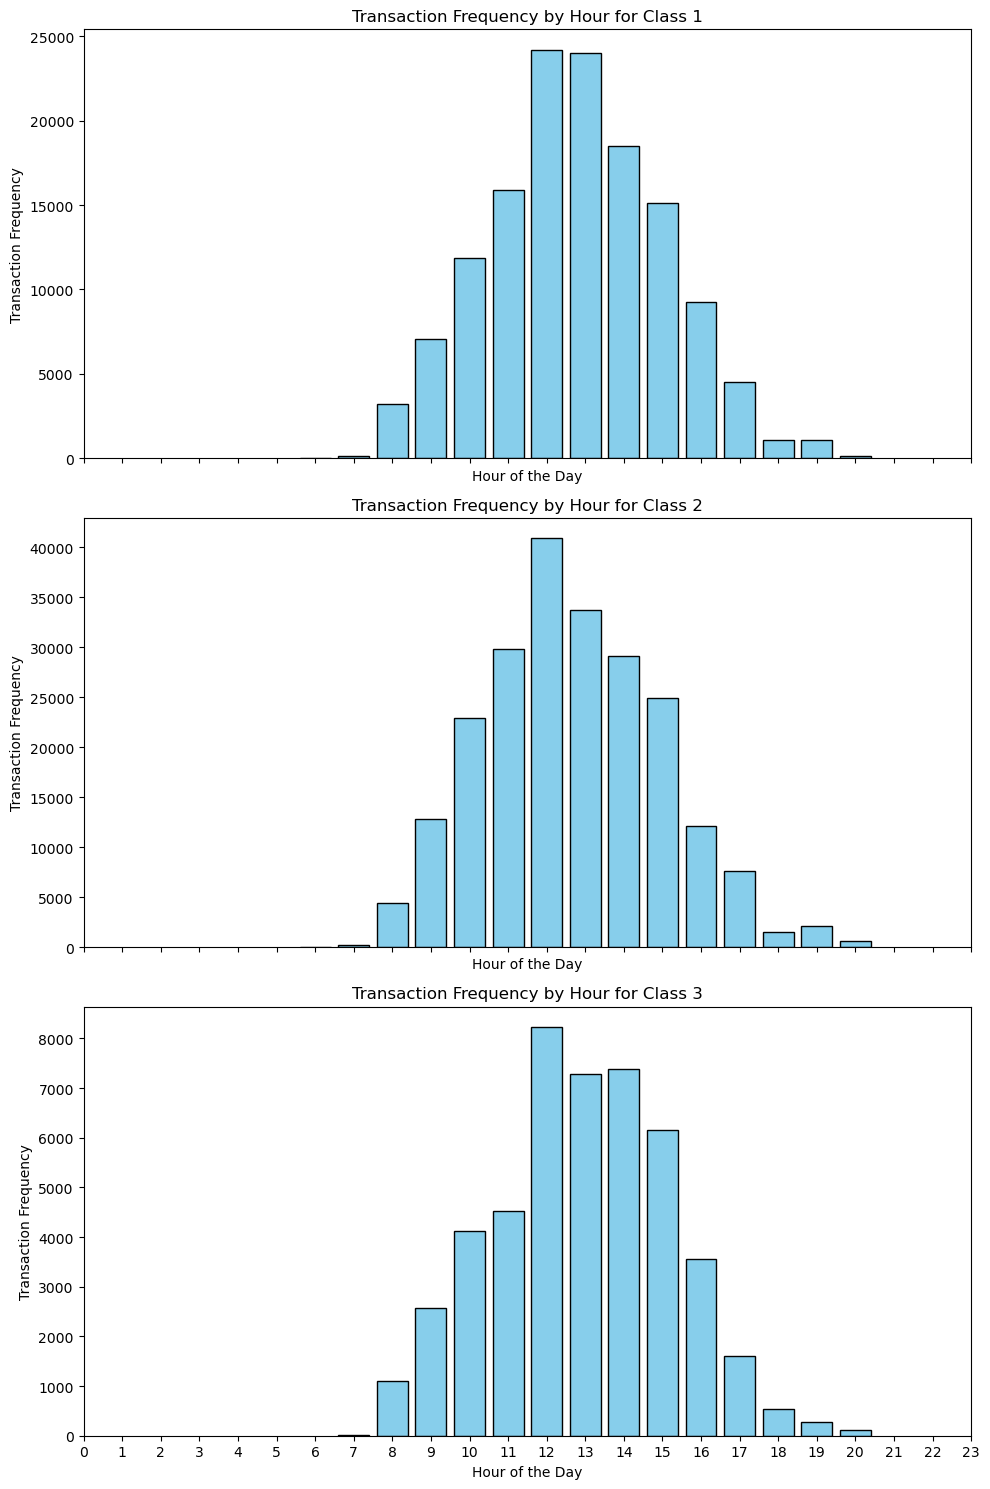

In [403]:
# PLot frequency to hour chart

unique_classes = df["class"].unique()
fig, axes = plt.subplots(len(unique_classes), 1, figsize=(10, 5 * len(unique_classes)), sharex=True)

# Plot transaction frequency per hour for each class
for i, class_label in enumerate(unique_classes[::-1]):
    class_df = df[df["class"] == class_label]  # Filter transactions for the class
    hourly_counts = class_df["Transaction_Hour"].value_counts().sort_index()  # Count transactions per hour

    # Bar plot
    axes[i].bar(hourly_counts.index, hourly_counts.values, color="skyblue", edgecolor="black")

    # Format x-axis (numbers 0-23 under every plot)
    axes[i].set_xticks(range(24))
    axes[i].set_xticklabels(range(24), fontsize=10)
    axes[i].set_ylabel("Transaction Frequency")
    axes[i].set_title(f"Transaction Frequency by Hour for Class {class_label}")
    axes[i].set_xlabel("Hour of the Day")  # Set x-label for every subplot

# Adjust layout to fit subplots properly
plt.tight_layout()
plt.show()

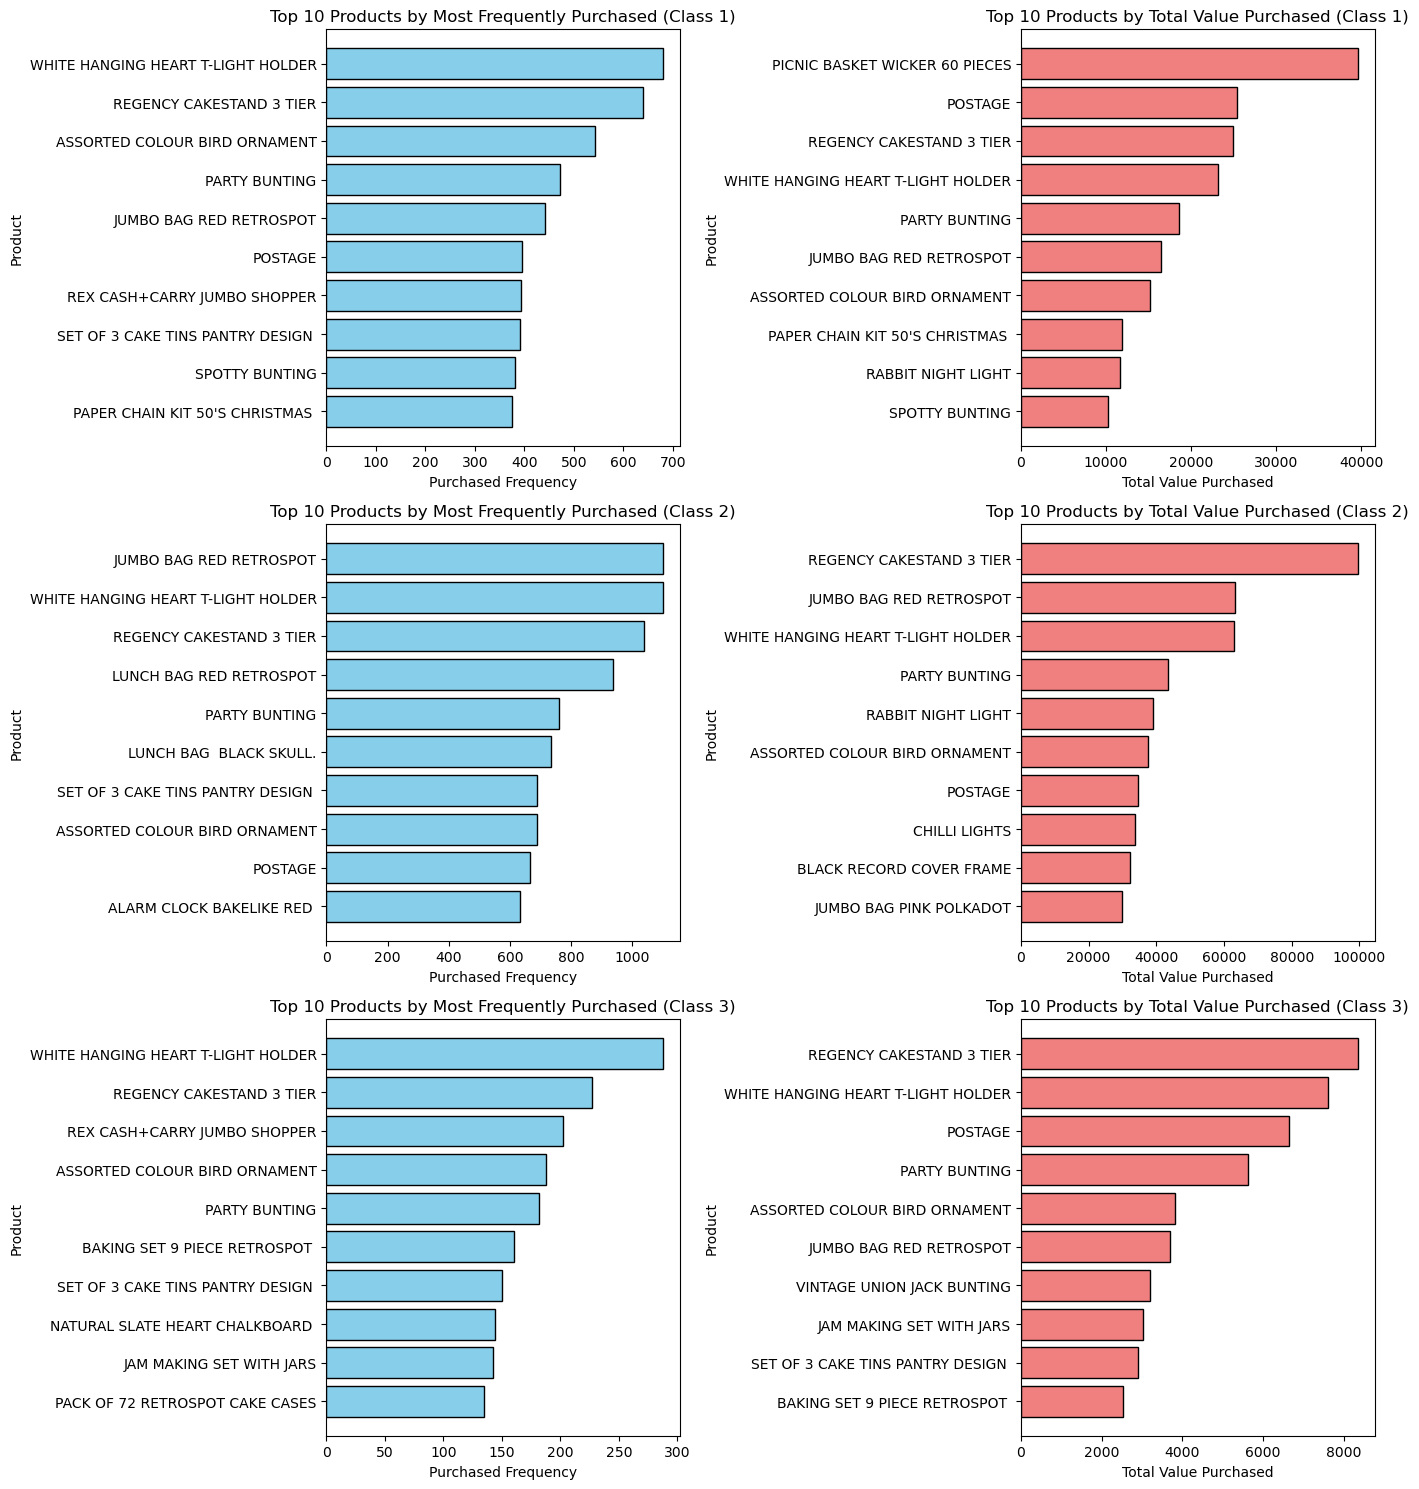

In [412]:
unique_classes = sorted(df["class"].unique())

# Set up the figure for multiple classes
fig, axes = plt.subplots(len(unique_classes), 2, figsize=(14, 5 * len(unique_classes)))

# Ensure axes is iterable when there's only one class
if len(unique_classes) == 1:
    axes = [axes]

# Plot for each class
for i, class_label in enumerate(unique_classes[::1]):
    class_df = df[df["class"] == class_label]  # Filter transactions for the class

    # Top 10 most purchased products
    top_products = class_df["Description"].value_counts().head(10)
    axes[i, 0].barh(top_products.index.astype(str), top_products.values, edgecolor='black', color='skyblue')
    axes[i, 0].set_xlabel("Purchased Frequency")
    axes[i, 0].set_ylabel("Product")
    axes[i, 0].set_title(f"Top 10 Products by Most Frequently Purchased (Class {class_label})")
    axes[i, 0].invert_yaxis()

    # Top 10 most purchased products based on total value purchased
    product_sales = class_df.groupby("Description")["Monetary"].sum()
    top_products_value = product_sales.nlargest(10)
    axes[i, 1].barh(top_products_value.index.astype(str), top_products_value.values, color='lightcoral', edgecolor='black')
    axes[i, 1].set_xlabel("Total Value Purchased")
    axes[i, 1].set_ylabel("Product")
    axes[i, 1].set_title(f"Top 10 Products by Total Value Purchased (Class {class_label})")
    axes[i, 1].invert_yaxis()

# Adjust layout to fit subplots properly
plt.tight_layout()
plt.show()